In [82]:
from PIL import Image
import numpy as np
import os, sys
from pathlib import Path
root_path = Path.cwd().parents[1]
if str(root_path) not in sys.path:
  sys.path.append(str(root_path))
print(f"{root_path=}")

root_path=PosixPath('/home/yy/Coding/GitHub/KataCV')


In [85]:
from katacv.yolov5.parser import get_args_and_writer
from katacv.yolov5.model import get_state
from katacv.utils.model_weights import load_weights

args = get_args_and_writer(no_writer=True, input_args="")
args.pretrain_backbone = False  # if don't use BN
# args.model_name = "YOLOv5_b32_stopD"
args.model_name = "YOLOv5_b32_scratch_stopD"
args.path_logs = root_path / "logs"
state = get_state(args, use_init=False)
# Load weight fully
args.path_cp = args.path_logs / "YOLOv5_b32_scratch_stopD-checkpoints"
args.load_id = 91
state = load_weights(state, args)

# Load weight from `-lite`
# from katacv.utils.related_pkgs.jax_flax_optax_orbax import ocp
# path_weight_lite = "/home/wty/Coding/models/YOLOv5/YOLOv5_b32_stopD-0127-lite"
# weights = ocp.PyTreeCheckpointer().restore(path_weight_lite)
# state = state.replace(params=weights['params'], batch_stats=weights['batch_stats'])

Successfully load weights from '/home/yy/Coding/GitHub/KataCV/logs/YOLOv5_b32_scratch_stopD-checkpoints/YOLOv5_b32_scratch_stopD-0091'


In [86]:
%load_ext autoreload
%autoreload 2
from katacv.yolov5.predict import Predictor
from katacv.utils.yolo.utils import show_box
# predict = Predictor(args, state, use_bn=False)
predict = Predictor(args, state, use_bn=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# img = []
# for p in Path("/home/wty/Pictures/model_test/test_image/8examples").glob('*.jpg'):
#   img.append(np.array(Image.open(str(p)).resize((640,640)).convert("RGB")))
# img = np.array(img)
# print(f"{len(img)=}, {img.dtype=}")
# for i in range(len(img)):
#   x = img[i:i+1].astype(np.float32) / 255.
#   pbox = predict_bad.update(x, nms_iou=0.65, nms_conf=0.01)
#   show_box(x[0], pbox[0])

In [87]:
from katacv.utils.yolo.build_dataset import DatasetBuilder
# args.path_dataset = Path("/home/wty/Coding/datasets/coco")
args.path_dataset = Path("/home/yy/Coding/datasets/coco")
args.batch_size = 1
ds_builder = DatasetBuilder(args)
train_ds = ds_builder.get_dataset(subset='train', use_cache=False)
val_ds = ds_builder.get_dataset(subset='val', use_cache=False)
iter_ds = iter(val_ds)

In [88]:
predict.reset()

In [115]:
# iter_ds = iter(train_ds)
x, tbox, tnum = next(iter_ds)
x, tbox, tnum = x.numpy().astype(np.float32) / 255., tbox.numpy(), tnum.numpy()
pbox = predict.update(x, tbox, tnum, nms_conf=0.2)
show_box(x[0], pbox[0])
print(predict.p_r_ap50_ap75_map())
# pbox = predict_bad.update(x, nms_conf=0.01)
# show_box(x[0], pbox[0])

(0.476962962962963, 0.4620718837116687, 0.43864246440277066, 0.2803837297809554, 0.2766012218650421)



(eog:278968): EOG-WARNING **: 20:17:29.278: Couldn't load icon: Icon 'image-loading' not present in theme candy-icons


In [ ]:
# Save current data
Image.fromarray((x[0]*255).astype(np.uint8)).save(path_debug / "origin.jpg")
with (path_debug / "sample_data.npy").open('wb') as file:
  np.save(
    file, {
      'x': x,
      'tbox': tbox,
      'tnum': tnum
    }, allow_pickle=True
  )

In [ ]:
print("tbox number:", tnum[0])
show_box(x[0], tbox[0][:tnum[0]])

In [ ]:
from katacv.yolov5.loss_debug import ComputeLoss
compute_loss = ComputeLoss(args)

In [ ]:
_, metrics = compute_loss.step(state_ok, x, tbox, tnum)
for val, name in zip(metrics, ['loss', 'lbox', 'lobj', 'lcls', 'l2']):
  if name not in ['loss', 'l2']:
    val *= 16
  print(name+':', val)

In [ ]:
_, metrics = compute_loss.step(state_bad, x, tbox, tnum)
for val, name in zip(metrics, ['loss', 'lbox', 'lobj', 'lcls', 'l2']):
  if name not in ['loss', 'l2']:
    val *= 16
  print(name+':', val)

In [ ]:
print(compute_loss.weight_decay)

In [ ]:
# from katacv.utils.related_pkgs.jax_flax_optax_orbax import *
# from katacv.yolov5.loss import cell2pixel
# @jax.jit
# def predict(state: train_state.TrainState, x: jnp.ndarray):
#   logits = state.apply_fn(
#     {'params': state.params, 'batch_stats': state.batch_stats},
#     x, train=False
#   )
#   y, batch_size = [], x.shape[0]
#   for i in range(3):
#     xy = (jax.nn.sigmoid(logits[i][...,:2]) - 0.5) * 2.0 + 0.5
#     xy = cell2pixel(xy, scale=2**(i+3))
#     wh = (jax.nn.sigmoid(logits[i][...,2:4]) * 2) ** 2 * args.anchors[i].reshape(1,3,1,1,2)
#     conf = jax.nn.sigmoid(logits[i][...,4:5])
#     cls = jax.nn.sigmoid(logits[i][...,5:])
#     conf = conf * jnp.max(cls, axis=-1, keepdims=True)
#     cls = jnp.argmax(cls, axis=-1, keepdims=True)
#     y.append(jnp.concatenate([xy,wh,conf,cls], -1).reshape(batch_size,-1,6))
#   y = jnp.concatenate(y, 1)  # shape=(batch_size,all_pbox_num,6)
#   return y
# p_ok = jax.device_get(predict(state_ok, x))
# p_bad = jax.device_get(predict(state_bad, x))

In [64]:
from tqdm import tqdm
# Test
from katacv.utils.yolo.build_dataset import DatasetBuilder
# args.path_dataset = Path("/home/wty/Coding/datasets/coco")
args.path_dataset = Path("/home/yy/Coding/datasets/coco")
args.batch_size = 1
ds_builder = DatasetBuilder(args)
train_ds = ds_builder.get_dataset(subset='train', use_cache=False)
val_ds = ds_builder.get_dataset(subset='val', use_cache=False)
predict.reset()
bar = tqdm(val_ds)
for x, tbox, tnum in bar:
  x, tbox, tnum = x.numpy().astype(np.float32) / 255.0, tbox.numpy(), tnum.numpy()
  pbox = predict.update(x, tbox, tnum, nms_conf=0.1)
  bar.set_description(' '.join([f"{n}: {v}" for n, v in zip(('p','r','ap50','ap75','map'), (predict.p_r_ap50_ap75_map()))]))
  break
print(predict.p_r_ap50_ap75_map())

p: 0.19333333333333333 r: 0.33999999999999997 ap50: 0.33193333333333336 ap75: 0.08293333333333333 map: 0.11091:   0%|          | 0/5000 [00:00<?, ?it/s]

(0.19333333333333333, 0.33999999999999997, 0.33193333333333336, 0.08293333333333333, 0.11091)


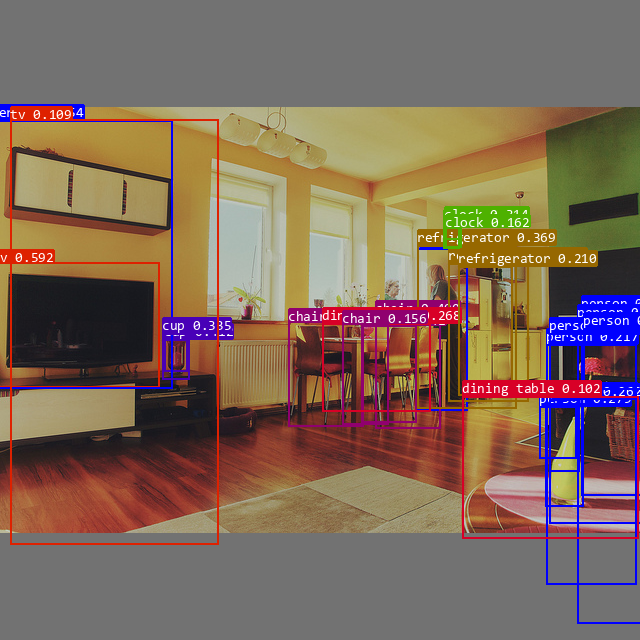


(eog:275763): EOG-WARNING **: 20:04:53.021: Couldn't load icon: Icon 'image-loading' not present in theme candy-icons


In [67]:
show_box(x[0], pbox[0])

In [55]:
print(np.concatenate(predict.tp, axis=0).shape)

(457650, 10)
